# Importing Data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import logging
import warnings
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Interlub/orders_preprocessed.csv')
df['date'] = pd.to_datetime(df['date'])
# Agrupar por semana y por 'product_id', sumando solo 'quantity'
df_weekly = df.groupby([pd.Grouper(key='date', freq='W'), 'product_id'])['quantity'].sum().reset_index()
df_weekly.head()

# Demand Forecasting

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from statsforecast.models import AutoETS
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

def AutoETS_forecast(product_id, product_series, horizon=1, level=[95]):
    sf_df = product_series.copy()
    sf_df['unique_id'] = str(product_id)
    sf_df = sf_df.sort_values('ds')

    # Initialize and fit model
    model = AutoETS(season_length=52, model='ZZZ')
    sf = StatsForecast(models=[model], freq='W', n_jobs=-1)
    sf.fit(sf_df)  # Note: Using sf_df (with unique_id) not product_series

    # Generate forecast dates
    last_date = sf_df['ds'].max()
    forecast_dates = pd.date_range(
        start=last_date + pd.Timedelta(weeks=1),
        periods=horizon,
        freq='W')

    # Make predictions
    forecast = sf.predict(h=horizon, level=level)

    # Return formatted results
    result = pd.DataFrame({'ds': forecast_dates, 'y_pred': forecast['AutoETS'].values})

    # Add confidence intervals
    for lvl in sorted(level):
        result[f'lo_{lvl}'] = forecast[f'AutoETS-lo-{lvl}'].values
        result[f'hi_{lvl}'] = forecast[f'AutoETS-hi-{lvl}'].values

    return result

In [ ]:
for product_id in ['IVP04039']:
    product_df = df_weekly[df_weekly['product_id'] == product_id].copy()
    product_df = product_df.sort_values('date')
    product_df = product_df.reset_index(drop=True)
    product_df = product_df.drop(columns=['product_id'])
    product_df = product_df.rename(columns={'date': 'ds', 'quantity': 'y'})

    predictions = AutoETS_forecast(product_id, product_df, horizon=4)
predictions

,ds,y_pred,lo_95,hi_95
0,2024-01-07,603.570174,130.784925,1076.355424
1,2024-01-14,610.271900,137.485616,1083.058184
2,2024-01-21,616.973626,144.183406,1089.763847
3,2024-01-28,623.675352,150.876422,1096.474282


# Inventory Optimization

In [ ]:
from scipy.stats import norm  # For safety stock calculations

def optimize_inventory(product_id, product_series, current_stock,
                      horizon=4, lead_time_weeks=2, service_level=0.95):
    """
    Args:
        product_id: Product identifier
        product_series: Historical data with columns ['ds', 'y']
        current_stock: Units currently in inventory
        horizon: Weeks to plan inventory for
        lead_time_weeks: Supplier lead time in weeks
        service_level: Target service level (e.g., 0.95 for 95%)
    Returns:
        DataFrame with recommended orders and inventory plan
    """
    # Get forecast with 95% CI

    forecast = AutoETS_forecast(product_id, product_series, horizon=horizon+lead_time_weeks, level=[95])

    # Calculate safety stock using the 95% CI and normal distribution (z-score)
    z_score = norm.ppf(service_level)
    forecast['safety_stock'] = (forecast['hi_95'] - forecast['y_pred']) * z_score

    # Lead time demand (sum of predictions during lead time)
    lead_time_demand = forecast['y_pred'].head(lead_time_weeks).sum()

    # Generate inventory plan
    plan = []
    for i in range(horizon):
        week_plan = {
            'date': forecast.iloc[i]['ds'],
            'predicted_demand': forecast.iloc[i]['y_pred'],
            'min_required': forecast.iloc[i]['lo_95'],
            'recommended_stock': forecast.iloc[i]['y_pred'] + forecast.iloc[i]['safety_stock'],
            'order_quantity': max(0,
                forecast.iloc[i]['y_pred']
                + forecast.iloc[i]['safety_stock']
                - current_stock
                + lead_time_demand)
        }
        plan.append(week_plan)
        current_stock = current_stock - forecast.iloc[i]['y_pred'] + week_plan['order_quantity']

    return pd.DataFrame(plan)

In [ ]:
for product_id in ['IVP04039']:
    product_df = df_weekly[df_weekly['product_id'] == product_id].copy()
    product_df = product_df.sort_values('date')
    product_df = product_df.reset_index(drop=True)
    product_df = product_df.drop(columns=['product_id'])
    product_df = product_df.rename(columns={'date': 'ds', 'quantity': 'y'})

    # Inputs
    current_inventory = 1000
    lead_time = 1  # Supplier takes 2 weeks to deliver
    service_level = 0.95  # 95% service level

    # Get optimized plan
    plan = optimize_inventory(
        product_id=product_id,
        product_series=product_df,
        current_stock=current_inventory,
        horizon=4,
        lead_time_weeks=lead_time,
        service_level=service_level
    )

plan

,date,predicted_demand,min_required,recommended_stock,order_quantity
0,2024-01-07,603.570174,130.784925,1381.232707,984.802881
1,2024-01-14,610.271900,137.485616,1387.936134,610.273601
2,2024-01-21,616.973626,144.183406,1394.644335,616.980101
3,2024-01-28,623.675352,150.876422,1401.360386,623.689677


# Loss Functions taking inventory cost

This function is an example of how a loss function might help us plan for inventory orders and adjust parameters like service level

In [ ]:
def calculate_inventory_costs(actual_demand, inventory_level, unit_cost,
                            holding_cost_pct, stockout_cost_factor):
    """
    Calculate total inventory costs over time
    """
    daily_costs = []

    for day, demand in enumerate(actual_demand):
        if inventory_level >= demand:
            # Excess inventory - holding cost
            excess = inventory_level - demand
            holding_cost = excess * unit_cost * (holding_cost_pct/365)  # Daily holding cost
            stockout_cost = 0
            inventory_level = excess
        else:
            # Stockout - opportunity cost and lost sales
            shortfall = demand - inventory_level
            holding_cost = 0
            stockout_cost = shortfall * unit_cost * stockout_cost_factor
            inventory_level = 0

        daily_costs.append(holding_cost + stockout_cost)

    return sum(daily_costs)

# Graphing
We graph real data backtested to simulate the system's performance, using the 3rd year of the provided data

In [ ]:
def rolling_autoets_forecast(
    product_id,
    product_series,
    horizon=1,
    retrain_every_x_weeks=1,
    level=[80, 95],  # Confidence intervals to display
    service_level=0.95,
):
    """Simulates weekly forecasts for the last year using a rolling window."""
    sf_df = product_series.copy()
    sf_df['unique_id'] = str(product_id)
    sf_df = sf_df.sort_values('ds')

    # Split into training (first 2 years) and test (last year)
    train_df = sf_df.iloc[:-52]  # First 104 weeks (2 years)
    test_df = sf_df.iloc[-52:]   # Last 52 weeks (1 year)

    # Initialize model
    model = AutoETS(season_length=52, model='ZZZ')
    sf = StatsForecast(models=[model], freq='W', n_jobs=-1)

    forecasts = []
    actuals = []
    cutoff_dates = []
    recommended_stock = []
    confidence_intervals = {f'lo_{lvl}': [] for lvl in level}
    confidence_intervals.update({f'hi_{lvl}': [] for lvl in level})

    for i in range(0, len(test_df), retrain_every_x_weeks):
        current_test = test_df.iloc[i:i+horizon]

        if i % retrain_every_x_weeks == 0:
            current_train = pd.concat([train_df, test_df.iloc[:i]])
            sf.fit(current_train)
            last_train_date = current_train['ds'].max()

        # Get predictions WITH intervals
        forecast = sf.predict(h=horizon, level=level)

        forecasts.extend(forecast['AutoETS'].values)
        actuals.extend(current_test['y'].values)
        cutoff_dates.extend([last_train_date] * len(current_test))

        # Store confidence intervals
        for lvl in level:
            confidence_intervals[f'lo_{lvl}'].extend(forecast[f'AutoETS-lo-{lvl}'].values)
            confidence_intervals[f'hi_{lvl}'].extend(forecast[f'AutoETS-hi-{lvl}'].values)

        # Get optimized plan
        plan = optimize_inventory(
            product_id=product_id,
            product_series=product_df,
            current_stock=current_inventory,
            horizon=horizon,
            lead_time_weeks=lead_time,
            service_level=service_level
        )
        recommended_stock.extend(plan['recommended_stock'].values)

    # Combine results
    results = test_df.copy()
    results['forecast'] = forecasts[:len(test_df)]
    results['error'] = results['y'] - results['forecast']
    results['last_train_date'] = cutoff_dates[:len(test_df)]
    results['recommended_stock'] = recommended_stock[:len(test_df)]

    # Add intervals to results
    for lvl in level:
        results[f'lo_{lvl}'] = confidence_intervals[f'lo_{lvl}'][:len(test_df)]
        results[f'hi_{lvl}'] = confidence_intervals[f'hi_{lvl}'][:len(test_df)]

    # Enhanced Plotting
    plt.figure(figsize=(16, 7))

    # 1. Plot training data
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue', alpha=0.4)

    # 2. Plot actuals
    plt.plot(results['ds'], results['y'], label='Actual Sales', color='green', marker='o', markersize=5)

    # 3. Plot forecasts
    plt.plot(results['ds'], results['forecast'], label=f'{horizon}-Week Forecasts',
             color='red', linestyle='--', marker='x')

    plt.plot(results['ds'], results['recommended_stock'], label=f'Recommended Stock at {service_level*100}% service level',
             color='purple', linestyle='--', marker='x')

    # 4. Plot confidence intervals (reverse order for proper layering)
    for lvl in sorted(level, reverse=True):
        plt.fill_between(
            results['ds'],
            results[f'lo_{lvl}'],
            results[f'hi_{lvl}'],
            alpha=0.15 if lvl==80 else 0.1,  # More opaque for tighter intervals
            label=f'{lvl}% Confidence',
            color='orange' if lvl==80 else 'gray'
        )

    # 5. Highlight retraining points
    for date in results['last_train_date'].unique():
        plt.axvline(date, color='purple', linestyle=':', alpha=0.3, linewidth=1)

    plt.title(f'Product X - {horizon}-Week Forecasts\n(Retrain every {retrain_every_x_weeks} weeks, Shaded=Confidence)')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

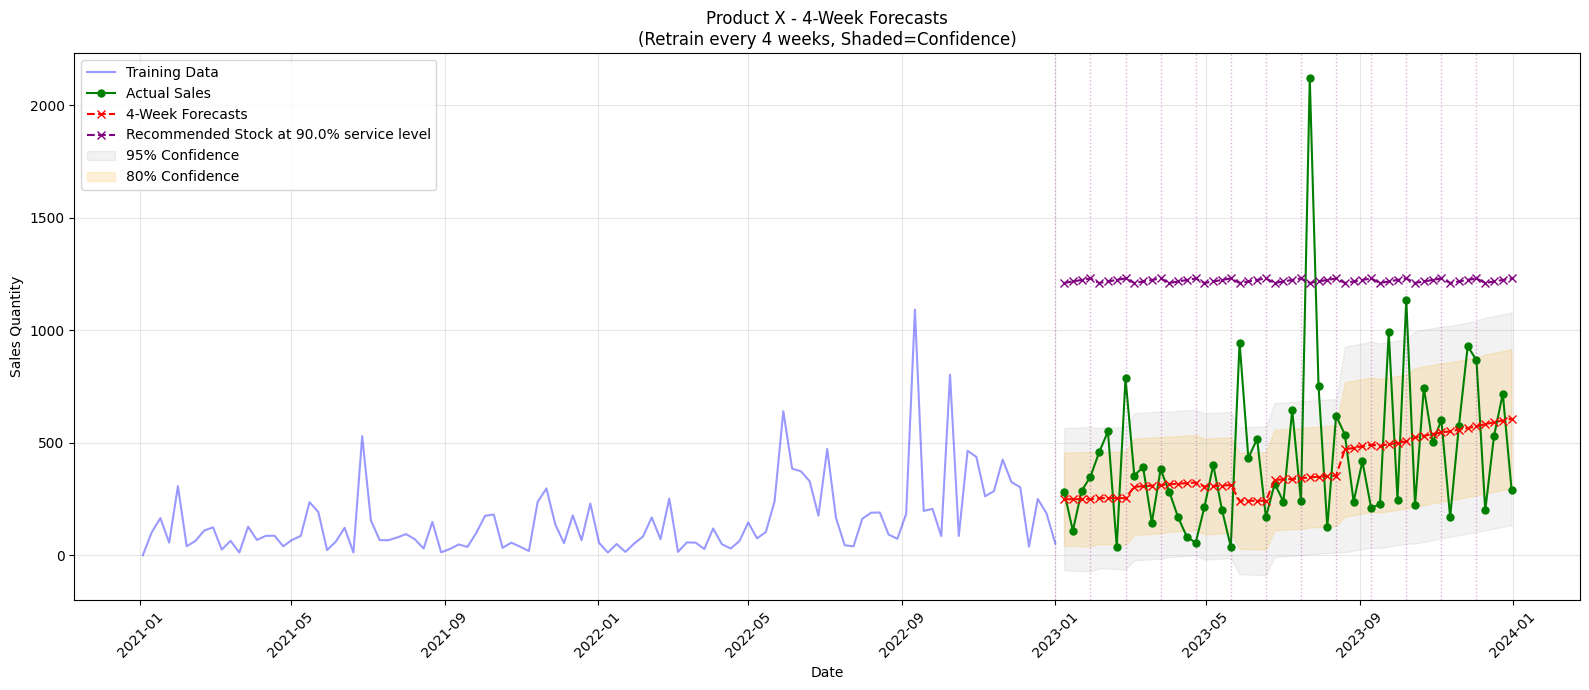

In [ ]:
products = df_weekly['product_id'].unique()

for product_id in ['IVP04039']:
    product_df = df_weekly[df_weekly['product_id'] == product_id].copy()
    product_df = product_df.sort_values('date')
    product_df = product_df.reset_index(drop=True)
    product_df = product_df.drop(columns=['product_id'])
    product_df = product_df.rename(columns={'date': 'ds', 'quantity': 'y'})
    result = rolling_autoets_forecast(product_id, product_df, retrain_every_x_weeks=4, horizon=4, service_level=.90)

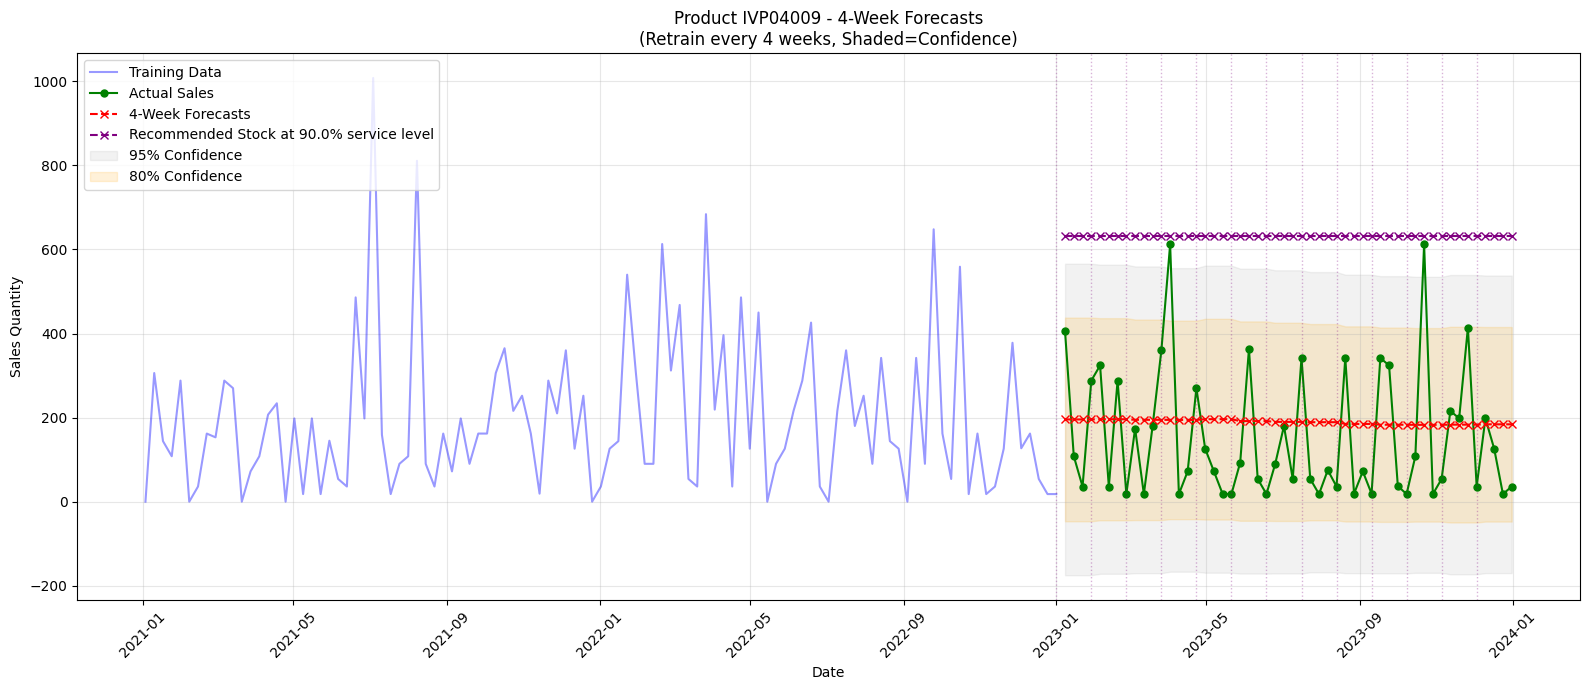

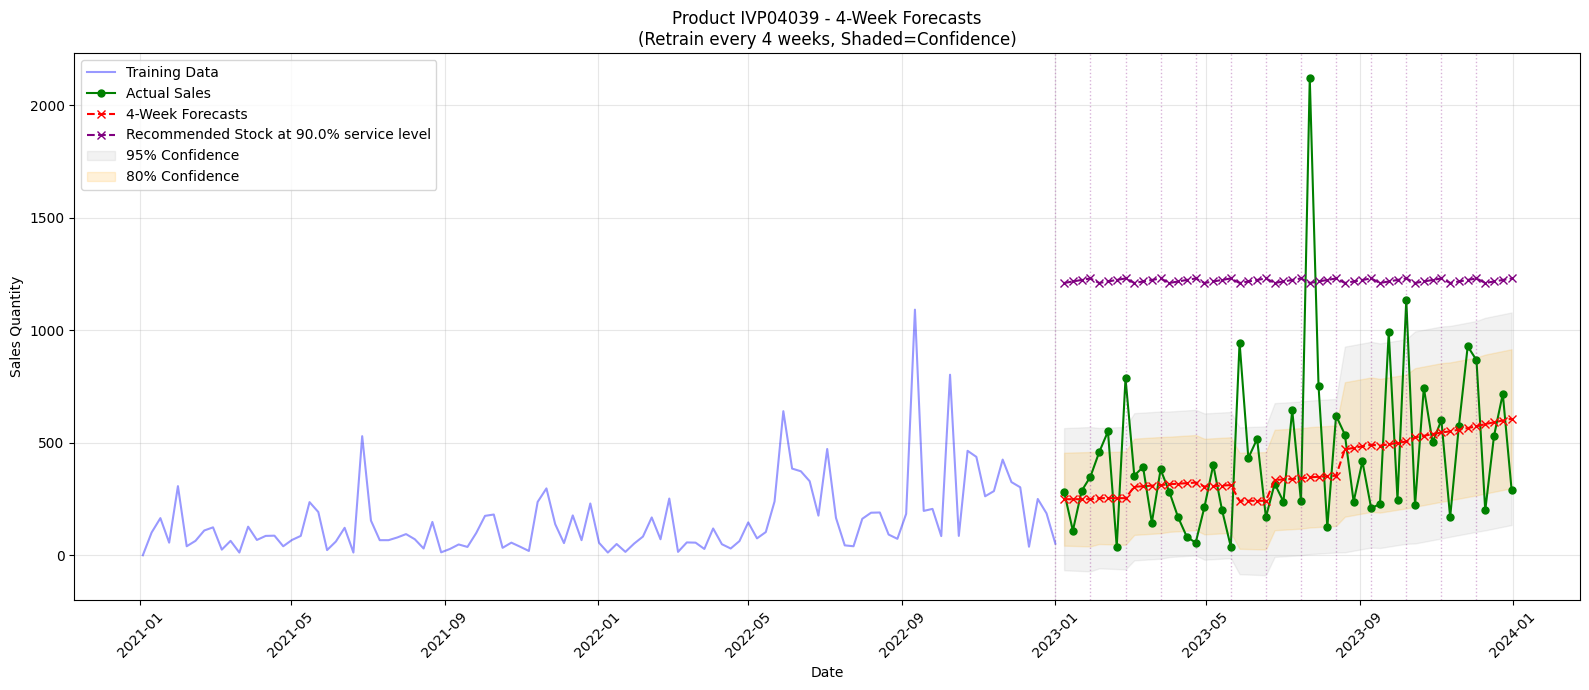

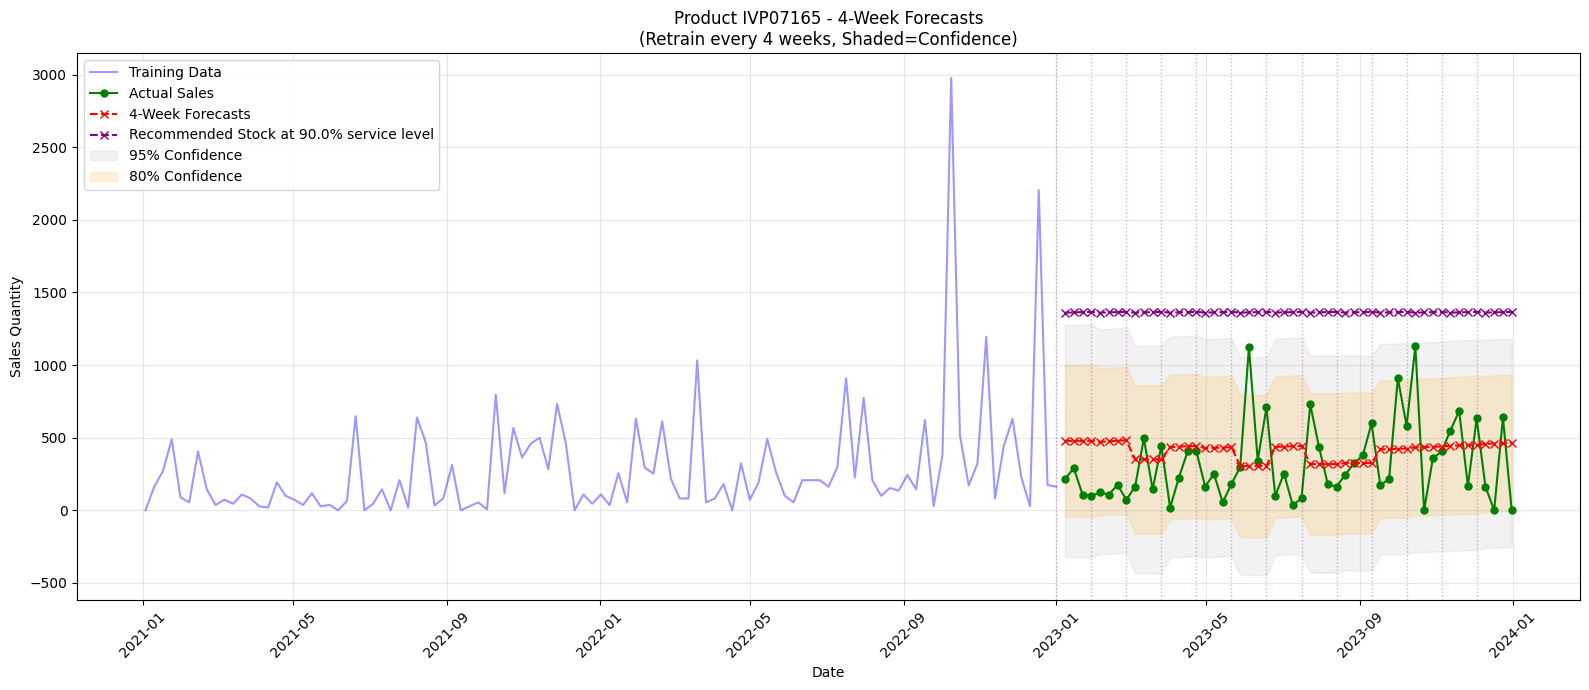

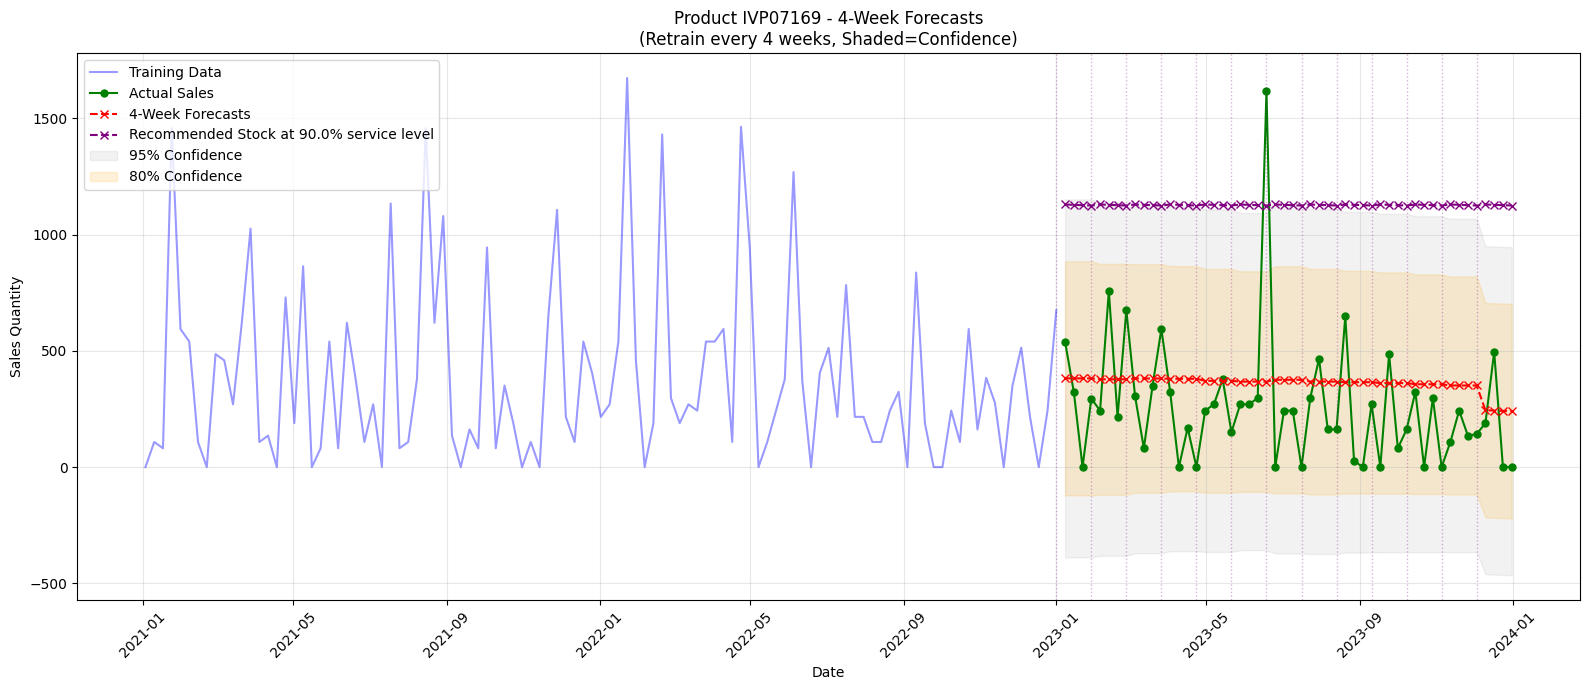

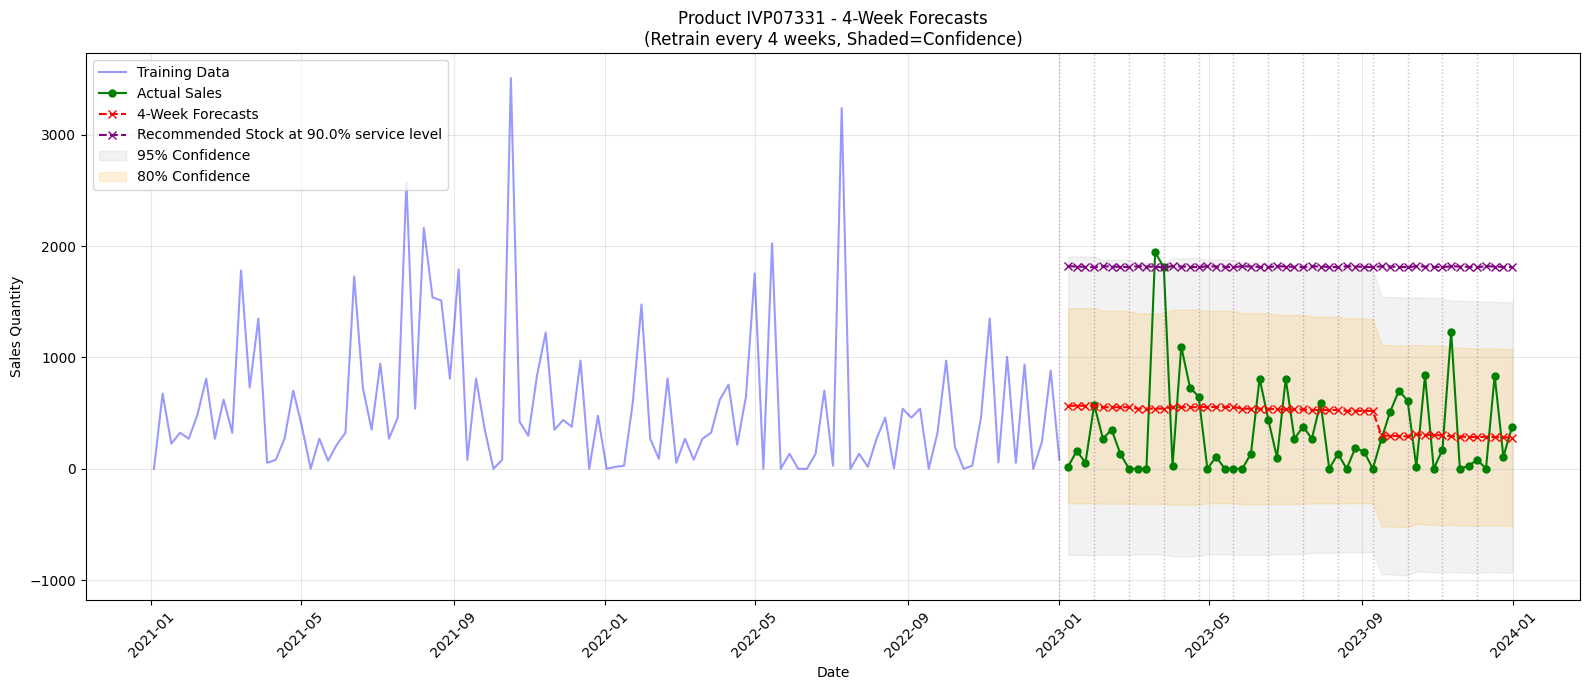

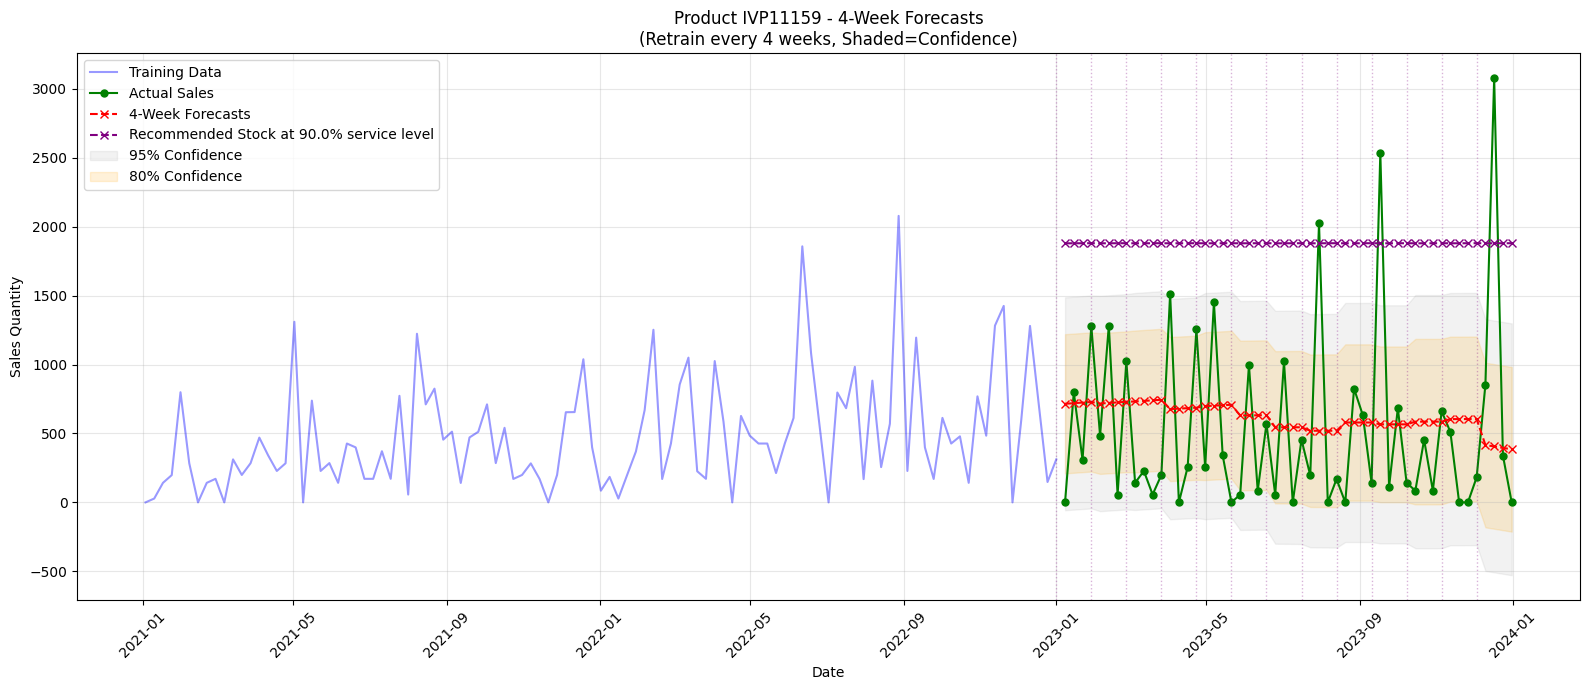

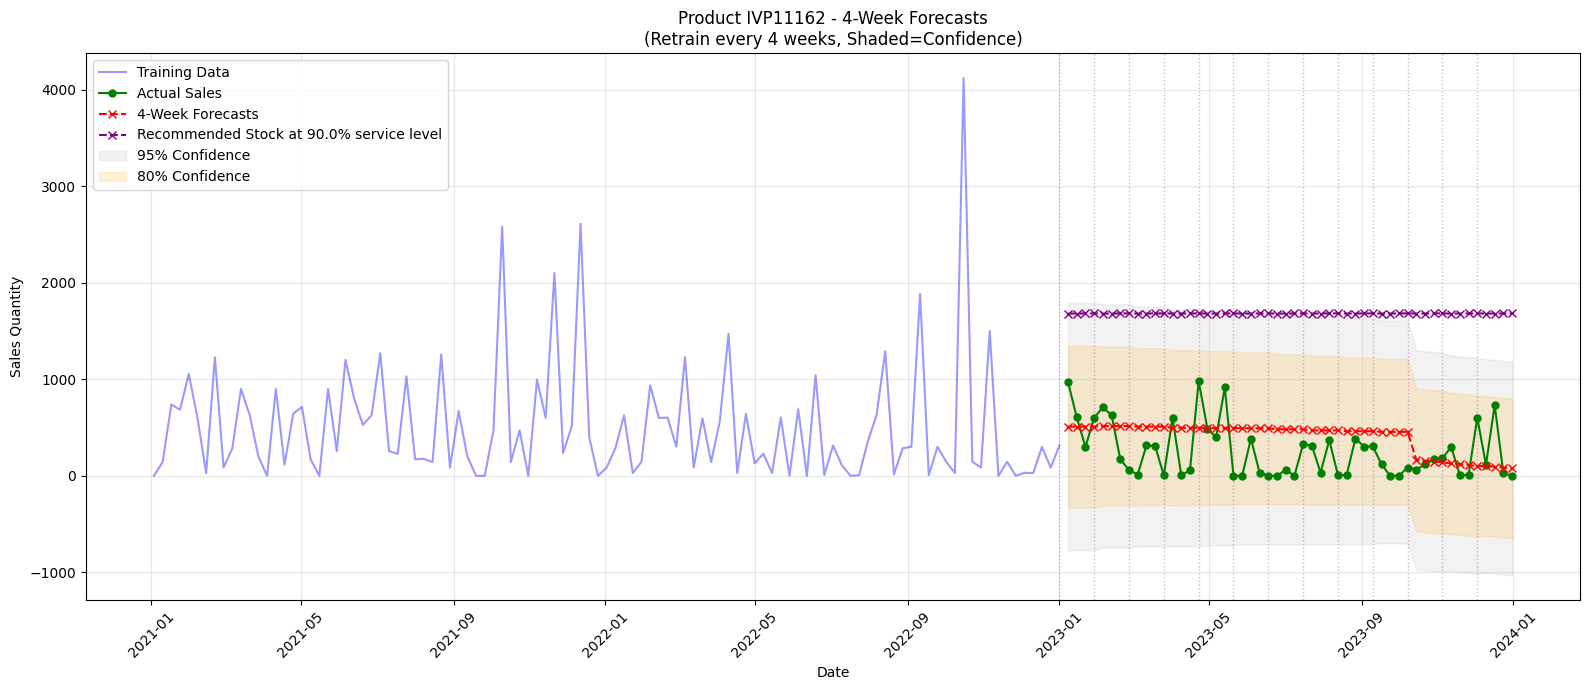

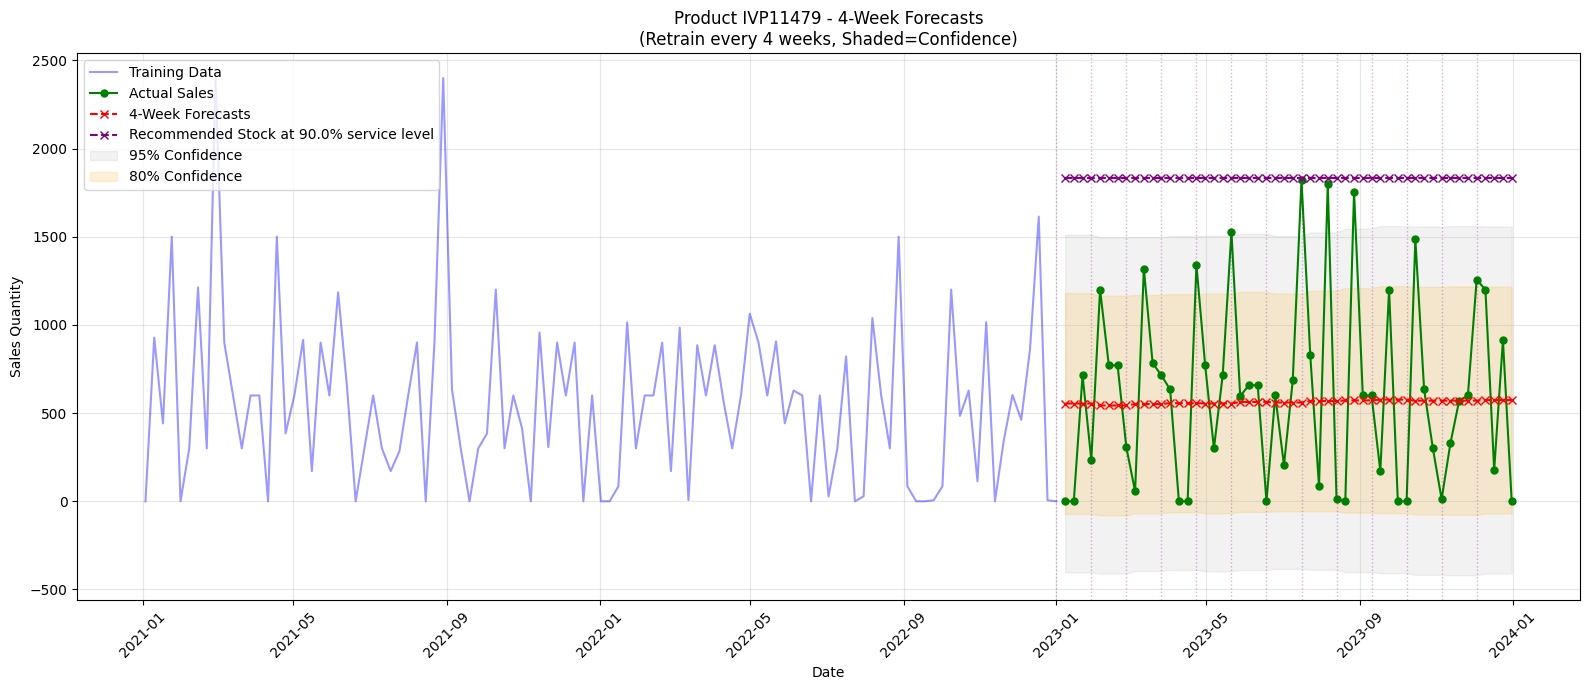

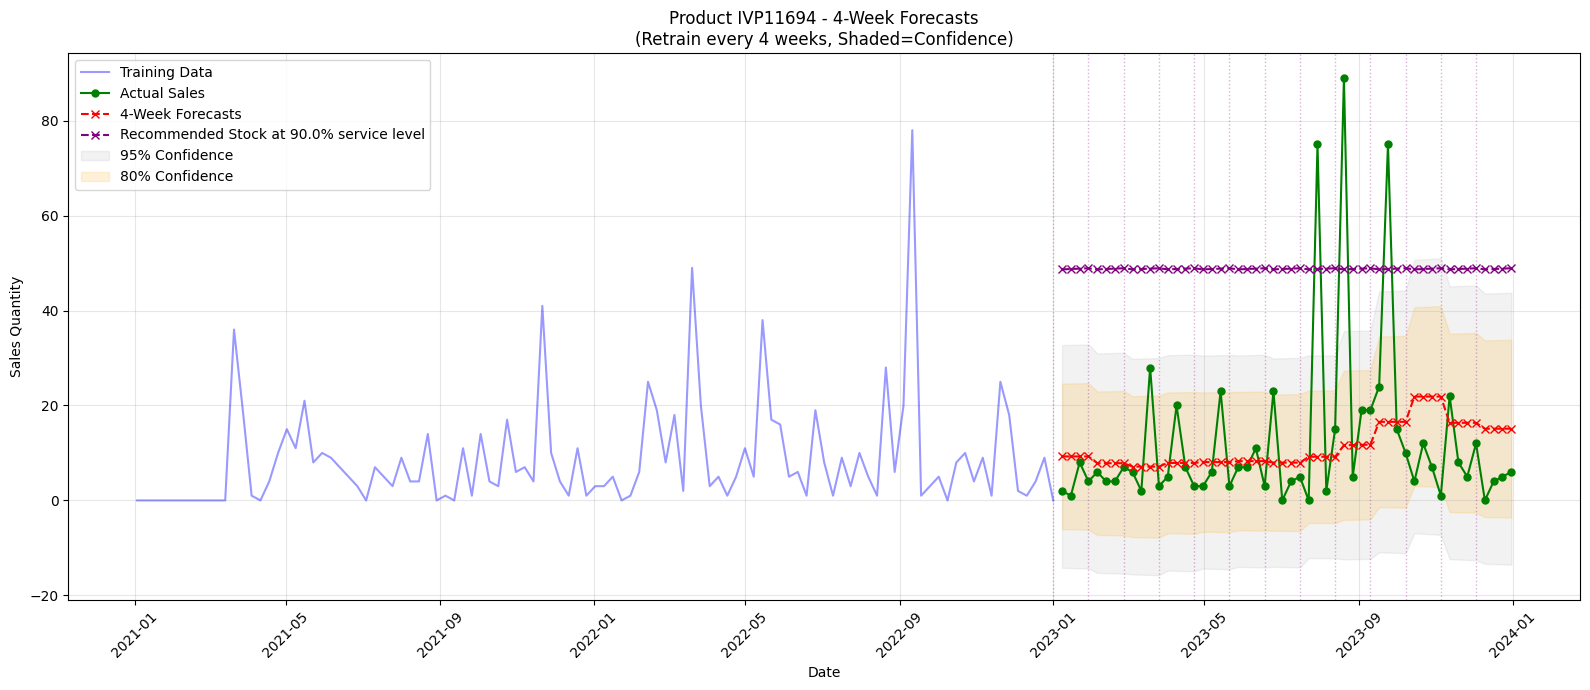

In [ ]:
products = df_weekly['product_id'].unique()

for product_id in ['IVP04009','IVP04039','IVP07165','IVP07169','IVP07331','IVP11159','IVP11162','IVP11479','IVP11694']:
    product_df = df_weekly[df_weekly['product_id'] == product_id].copy()
    product_df = product_df.sort_values('date')
    product_df = product_df.reset_index(drop=True)
    product_df = product_df.drop(columns=['product_id'])
    product_df = product_df.rename(columns={'date': 'ds', 'quantity': 'y'})
    result = rolling_autoets_forecast(product_id, product_df, retrain_every_x_weeks=4, horizon=4, service_level=.90)